# Python Kafka Client Benchmarking

[Kafka]() is an incredibly powerful service that can help you process huge streams of data. It is written in Scala and has been undergoing lots of changes. Historically, the JVM clients have been better supported then those in the Python ecosystem. However, this doesn't need to be case! The Kafka binary protocol has largely solidified and many people in open source community are working to provide first class support for non-JVM langauges.

In this post we will benchmark the three main Python Kafka clients. [pykafka](), [python-kafka]() and the newest arrival [confluent-kafka-client](). This will also be useful as an introduction to the different clients in the python ecosystem and their high level APIs.

#  Setup and Caveat
We are going to keep the setup simple and run a single broker that will auto-create topics with one partition. Please note this is a contrived setup. Any production deployment would be multi-broker and likely more partitions, but for simplicity sake we are going to use one.

### The Plan
- Spin up a single kafka 0.9 broker

- We are going to produce and consume 1 million 100 bytes messages with each client.

- We will require a producer `acks` of 1. meaning that only the leader (we one have one broker anyways) needs to ack a message. Increasing this will ensure your data is not lost due to broker failure but will slow down production.


### Caveat
Like all benchmarks, take this with a grain of salt. All settings are largely left to their defaults. Also, the amount of file caching broker does really help the client consumption speed. Even with all the normal stipulation, I hope you find this informative.

Included in this repo is a docker-compose file that will spin up a kafka 0.9 broker and zookeeper locally. We can shell out and start it with docker compose.

In [1]:
!docker-compose up -d

Creating network "pythonkafkabenchmark_default" with the default driver
Creating pythonkafkabenchmark_zookeeper_1
Creating pythonkafkabenchmark_kafka_1


In [2]:
msg_count = 1000000
msg_size = 100
msg_payload = ('kafkatest' * 20).encode()[:msg_size]
print(msg_payload)
print(len(msg_payload))

b'kafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestkafkatestk'
100


In [3]:
bootstrap_servers = 'localhost:9092'

In [4]:
import time
from tqdm import tqdm, tqdm_notebook

producer_timings = {}
consumer_timings = {}

In [43]:
def calculate_thoughput(timing, n_messages=1000000, msg_size=100):
    print("Processed {0} messsages in {1:.2f} seconds".format(n_messages, timing))
    print("{0:.2f} MB/s".format((msg_size * n_messages) / timing / (1024*1024)))
    print("{0:.2f} Msgs/s".format(n_messages / timing))

In [24]:
from pykafka import KafkaClient

def pykafka_producer_performance(use_rdkafka=False):
    
    # Setup client
    client = KafkaClient(hosts=bootstrap_servers)
    topic = client.topics[b'pykafka-test-topic']
    producer = topic.get_producer(use_rdkafka=use_rdkafka)

    msgs_produced = 0
    produce_start = time.time()
    for i in range(msg_count):
        # Start producing
        producer.produce(msg_payload)
                     
    producer.stop() # Will flush background queue
 
    return time.time() - produce_start

In [25]:
producer_timings['pykafka_producer'] = pykafka_producer_performance()
calculate_thoughput(producer_timings['pykafka_producer'])

If you are runnning this notebook live you will notice that the progress bar stalls at the very end. This is becuase the producer is asynchronous and batches produce calls to Kafka. 

Kafka's speed comes from the ability to batch many message together. To take advatage of this, the client will keep a buffer of messages in the background and batch them. So, when you call `producer.produce` you are performing no external I/O. That message is queued in an inmemory buffer and the method returns immediately. So we are able to load the inmemmory buffer faster then pykafka can send them to kafka. `producer.stop()` will block until all messages are sent.

So when producing messages make sure you allow the producer to flush the remaining messages before you exit.

Another way to ensure that the messages where produced is to check the topic offsets.

In [20]:
client = KafkaClient(hosts=bootstrap_servers)
topic = client.topics[b'pykafka-test-topic']
print(topic.earliest_available_offsets())
print(topic.latest_available_offsets())

{0: OffsetPartitionResponse(offset=[0], err=0)}
{0: OffsetPartitionResponse(offset=[4219300], err=0)}


Pykafka has an optional producer backend that wraps the [librdkafka](https://github.com/edenhill/librdkafka) package. librdkafka is a pure C kafka client and hold very impressive benchmarkers. Let rerun our pykafka producer test with rdkafka enabled.

In [44]:
producer_timings['pykafka_producer_rdkafka'] = pykafka_producer_performance(use_rdkafka=True)
calculate_thoughput(producer_timings['pykafka_producer_rdkafka'])

Processed 1000000 messsages in 13.95 seconds
6.84 MB/s
71690.73 Msgs/s


In [46]:
def pykafka_consumer_performance(use_rdkafka=False):
    # Setup client
    client = KafkaClient(hosts=bootstrap_servers)
    topic = client.topics[b'pykafka-test-topic']
    consumer = topic.get_simple_consumer(use_rdkafka=use_rdkafka)

    msg_consumed_count = 0

    consumer_start = time.time()
    consumer = topic.get_simple_consumer(use_rdkafka=use_rdkafka)

    while True:
        msg = consumer.consume()
        if msg:
            msg_consumed_count += 1

        if msg_consumed_count >= msg_count:
            break
                        
    consumer_timing = time.time() - consumer_start
    consumer.stop()    
    return consumer_timing

In [55]:
_ = pykafka_consumer_performance(use_rdkafka=False)
consumer_timings['pykafka_consumer'] = pykafka_consumer_performance(use_rdkafka=False)
calculate_thoughput(consumer_timings['pykafka_consumer'])

Processed 1000000 messsages in 31.42 seconds
3.03 MB/s
31823.79 Msgs/s


In [54]:
# run it once thorough to warm the cache
_ = pykafka_consumer_performance(use_rdkafka=True)
consumer_timings['pykafka_consumer_rdkafka'] = pykafka_consumer_performance(use_rdkafka=True)
calculate_thoughput(consumer_timings['pykafka_consumer_rdkafka'])

Processed 1000000 messsages in 6.81 seconds
14.01 MB/s
146885.09 Msgs/s


# [kafka-python]()
kafka-python aims to replicate the java client api exactly. This is a key difference with pykafka, which trys to maintains "pythonic" api. In earlier versions of kafka, partition balancing was left to the client. Pykafka was the only python client to implement this feature. However, with kafka 0.9 the broker provides this, so the lack of support within kafka-python is less important.

In [28]:
from kafka import KafkaProducer

def python_kafka_producer_performance():
    producer = KafkaProducer(bootstrap_servers=bootstrap_servers)

    producer_start = time.time()
    topic = 'python-kafka-topic'
    for i in range(msg_count):
        producer.send(topic, msg_payload)
        producer.flush()
        
    return time.time() - producer_start

In [27]:
producer_timings['python_kafka_producer'] = python_kafka_producer_performance()

In [51]:
from kafka import KafkaConsumer
import uuid

def python_kafka_consumer_performance():
    topic = 'python-kafka-topic'
    consumer = KafkaConsumer(bootstrap_servers=bootstrap_servers, group_id=uuid.uuid1())
    msg_consumed_count = 0
            
    consumer_start = time.time()
    consumer.subscribe([topic])
    for msg in consumer:
        msg_consumed_count += 1
                
        if msg_consumed_count >= msg_count:
            break
                    
    consumer_timing = time.time() - consumer_start
    consumer.stop()    
    return consumer_timing

In [31]:
_ = python_kafka_consumer_performance()
consumer_timings['python_kafka_consumer'] = python_kafka_consumer_performance()

KeyboardInterrupt: 

# [confluent-kafka-python](https://github.com/confluentinc/confluent-kafka-python)

With the latest release of the Confluent platform, there is a new python client on the scene. confluent-kafka-python is a python wrapper around librdkafka and is largely built by the same author. The underlying library is basis for most non-JVM clients out there. We have already mentioned it earlier when looking at pykafka.

In [63]:
import confluent_kafka

def confluent_kafka_producer_performance():
    
    conf = {'bootstrap.servers': bootstrap_servers}
    producer = confluent_kafka.Producer(**conf)

    producer_start = time.time()
    for i in range(msg_count):
        try:
            producer.produce('test', value=msg_payload)      
        except BufferError as e:
            time.sleep(0.001) # HACK!!!
            producer.produce('test', value=msg_payload)
            raise e         
        producer.poll(0)
    producer.flush()
            
    return time.time() - producer_start

In [65]:
producer_timings['confluent_kafka_producer'] = confluent_kafka_producer_performance()
calculate_thoughput(producer_timings['confluent_kafka_producer'])

Processed 1000000 messsages in 4.81 seconds
19.81 MB/s
207765.53 Msgs/s


In [67]:
import confluent_kafka
import uuid

def confluent_kafka_consumer_performance():
    
    msg_consumed_count = 0
    conf = {'bootstrap.servers': bootstrap_servers,
            'group.id': uuid.uuid1(),
            'session.timeout.ms': 6000,
            'default.topic.config': {
                'auto.offset.reset': 'earliest'
            }
    }

    consumer = confluent_kafka.Consumer(**conf)

    consumer_start = time.time()
    consumer.subscribe(["test"])

    while True:
        msg = consumer.poll(1)
        if msg:
            msg_consumed_count += 1
                         
        if msg_consumed_count >= msg_count:
            break
                    
    consumer_timing = time.time() - consumer_start
    consumer.close()    
    return consumer_timing

In [70]:
_ = confluent_kafka_consumer_performance() # Warm cache
consumer_timings['confluent_kafka_consumer'] = confluent_kafka_consumer_performance()
calculate_thoughput(consumer_timings['confluent_kafka_consumer'])

Processed 1000000 messsages in 3.83 seconds
24.90 MB/s
261123.87 Msgs/s


The confluent_kafka client is crushingly fast. It can consume over 250K mesasges a second. Note that the raw C client has been benchmarked at over 3 million messages/sec, so you see how much overhead python adds. But on the side of developer speed, you don't have to code in C! 

# Comparision

In [65]:
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [113]:
consumer_df = pd.DataFrame.from_dict(consumer_timings, orient='index').rename(columns={0: 'time_in_seconds'})
producer_df = pd.DataFrame.from_dict(producer_timings, orient='index').rename(columns={0: 'time_in_seconds'})

In [114]:
consumer_df['MBs/s'] = (len(msg_payload) * msg_count) / consumer_df.time_in_seconds / (1024*1024)
producer_df['MBs/s'] = (len(msg_payload) * msg_count) / producer_df.time_in_seconds / (1024*1024)

consumer_df['Msgs/s'] = msg_count / consumer_df.time_in_seconds
producer_df['Msgs/s'] = msg_count / producer_df.time_in_seconds

In [115]:
producer_df

,time_in_seconds,MBs/s,Msgs/s
pykafka_producer_rdkafka,11.648620,8.187016,85847.079691
pykafka_produce_time,58.277393,1.636440,17159.312571
confluent_kafka_producer,5.907958,16.142200,169263.233678


In [116]:
consumer_df

,time_in_seconds,MBs/s,Msgs/s
pykafka_consumer,41.169512,2.316458,24289.818966
confluent_kafka_consumer,3.947202,24.160768,253344.016420
pykafka_consumer_rdkafka,10.528306,9.058194,94982.045981


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcd313d8d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fbcd31225c0>], dtype=object)

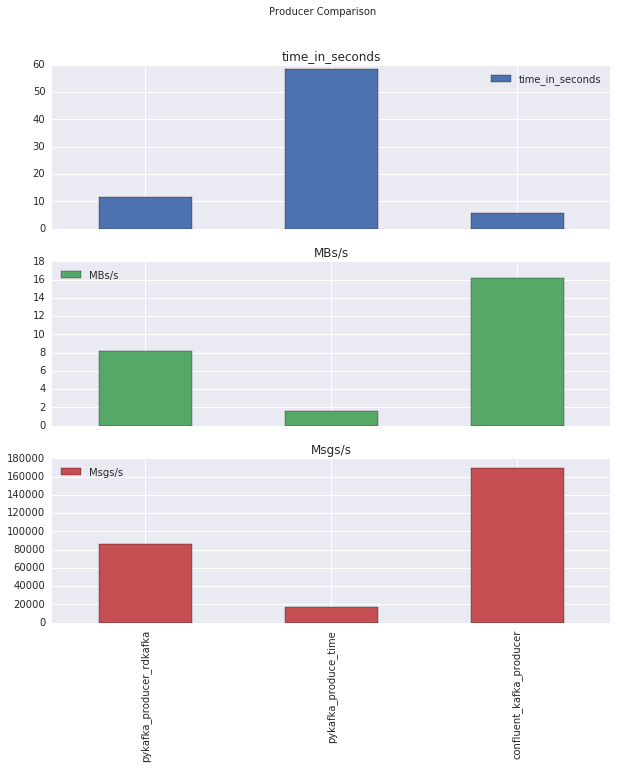

In [117]:
producer_df.plot(kind='bar', subplots=True, figsize=(10, 10), title="Producer Comparison")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbcd312f390>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fbcd2f0ac50>], dtype=object)

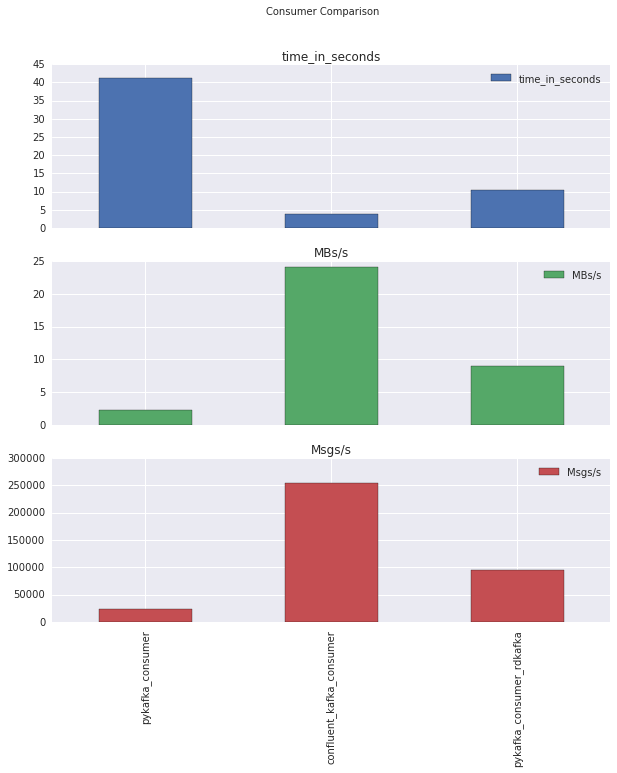

In [118]:
consumer_df.plot(kind='bar', subplots=True, figsize=(10, 10), title="Consumer Comparison")

# Limitations

This is not a complete overview of these clients. There are many tradeoffs to consider before you jump and pick one. First, is the confluent and rdkafka version of pykafka are C backed and will not work with pypy. The confluent_kafka client was released on May 25th, so while the underlying librdkafka is hardened, the python client is very fresh. Also, some of the metadata APIs are not exposed to the client, specifically the Offset API and Offset Commit/Fetch API. So getting the starting and ending offset for a partition and the current lag of a consumer group is not straight forward. Confluent seems committed to the client, so im sure a sane client api will be added.

# Conclusion

It is really exctiting to see the python ecosystem around Kafka develop. Python is wonderful langauge, having first class support for Kafka is huge for our work here at Activision and for anyone who is interested in stream processing and streaming analytics.

In [37]:
!docker-compose down # Cleanup

Removing network pythonkafkabenchmark_default
